NBEATS EXAMPLE
https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
It's a toy example to show how to do time series forecasting using N-Beats.

In [1]:
%matplotlib inline
import os

import matplotlib.pyplot as plt
import torch
from torch import optim
from torch.nn import functional as F
import pandas as pd
import numpy as np

from data import get_m4_data, dummy_data_generator
from nbeats_pytorch.model import NBeatsNet # some import from the trainer script e.g. load/save functions.

CHECKPOINT_NAME = 'nbeats-training-checkpoint.th'

# https://datamarket.com/data/set/22ox/monthly-milk-production-pounds-per-cow-jan-62-dec-75#!ds=22ox&display=line
# It's a toy example to show how to do time series forecasting using N-Beats.

In [2]:
# plot utils.
def plot_scatter(*args, **kwargs):
    plt.plot(*args, **kwargs)
    plt.scatter(*args, **kwargs)


# simple batcher.
def data_generator(x_full, y_full, bs):
    def split(arr, size):
        arrays = []
        while len(arr) > size:
            slice_ = arr[:size]
            arrays.append(slice_)
            arr = arr[size:]
        arrays.append(arr)
        return arrays

    while True:
        for rr in split((x_full, y_full), bs):
            yield rr

In [3]:
# trainer
def train_100_grad_steps(data, device, net, optimiser, test_losses):
    global_step = load(net, optimiser)
    for x_train_batch, y_train_batch in data:
        global_step += 1
        optimiser.zero_grad()
        net.train()
        _, forecast = net(torch.tensor(x_train_batch, dtype=torch.float).to(device))
        loss = F.mse_loss(forecast, torch.tensor(y_train_batch, dtype=torch.float).to(device))
        loss.backward()
        optimiser.step()
        if global_step % 30 == 0:
            print(f'grad_step = {str(global_step).zfill(6)}, tr_loss = {loss.item():.6f}, te_loss = {test_losses[-1]:.6f}')
        if global_step > 0 and global_step % 100 == 0:
            with torch.no_grad():
                save(net, optimiser, global_step)
            break

In [4]:
def load(model, optimiser):
    if os.path.exists(CHECKPOINT_NAME):
        checkpoint = torch.load(CHECKPOINT_NAME)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimiser.load_state_dict(checkpoint['optimizer_state_dict'])
        grad_step = checkpoint['grad_step']
        print(f'Restored checkpoint from {CHECKPOINT_NAME}.')
        return grad_step
    return 0

def save(model, optimiser, grad_step):
    torch.save({
        'grad_step': grad_step,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimiser.state_dict(),
    }, CHECKPOINT_NAME)

In [5]:
# evaluate model on test data and produce some plots.
def eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test):
    net.eval()
    _, forecast = net(torch.tensor(x_test, dtype=torch.float))
    test_losses.append(F.mse_loss(forecast, torch.tensor(y_test, dtype=torch.float)).item())
    p = forecast.detach().numpy()
    subplots = [221, 222, 223, 224]
    plt.figure(1)
    for plot_id, i in enumerate(np.random.choice(range(len(x_test)), size=4, replace=False)):
        ff, xx, yy = p[i] * norm_constant, x_test[i] * norm_constant, y_test[i] * norm_constant
        plt.subplot(subplots[plot_id])
        plt.grid()
        plot_scatter(range(0, backcast_length), xx, color='b')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), yy, color='g')
        plot_scatter(range(backcast_length, backcast_length + forecast_length), ff, color='r')
    plt.show()

In [6]:
# main
if os.path.isfile(CHECKPOINT_NAME):
    os.remove(CHECKPOINT_NAME)
device = torch.device('cpu')  # use the trainer.py to run on GPU.
forecast_length = 5
backcast_length = 3 * forecast_length
batch_size = 10  # greater than 4 for viz

milk = pd.read_csv('data/milk.csv', index_col=0, parse_dates=True)

print(milk.head())
milk = milk.values  # just keep np array here for simplicity.
norm_constant = np.max(milk)
milk = milk / norm_constant  # small leak to the test set here.

x_train_batch, y = [], []
for i in range(backcast_length, len(milk) - forecast_length):
    x_train_batch.append(milk[i - backcast_length:i])
    y.append(milk[i:i + forecast_length])

x_train_batch = np.array(x_train_batch)[..., 0]
y = np.array(y)[..., 0]

c = int(len(x_train_batch) * 0.8)
x_train, y_train = x_train_batch[:c], y[:c]
x_test, y_test = x_train_batch[c:], y[c:]

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

            milk_production_pounds
month                             
1962-01-01                     589
1962-02-01                     561
1962-03-01                     640
1962-04-01                     656
1962-05-01                     727
(118, 15) (30, 15)
(118, 5) (30, 5)


In [7]:
# model
net = NBeatsNet(stack_types=[NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK],
                forecast_length=forecast_length,
                thetas_dims=[7, 8],
                nb_blocks_per_stack=3,
                backcast_length=backcast_length,
                hidden_layer_units=128,
                share_weights_in_stack=False,
                device=device)
optimiser = optim.Adam(net.parameters())

| N-Beats
| --  Stack Generic (#0) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4749414992
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4749411408
     | -- GenericBlock(units=128, thetas_dim=7, backcast_length=15, forecast_length=5, share_thetas=False) at @4749413456
| --  Stack Generic (#1) (share_weights_in_stack=False)
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4749416720
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4344184976
     | -- GenericBlock(units=128, thetas_dim=8, backcast_length=15, forecast_length=5, share_thetas=False) at @4749383248


In [8]:
# data
data = data_generator(x_train, y_train, batch_size)

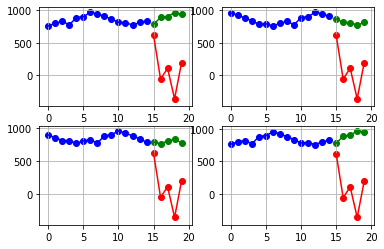

grad_step = 000030, tr_loss = 0.015773, te_loss = 0.724115
grad_step = 000060, tr_loss = 0.005873, te_loss = 0.724115
grad_step = 000090, tr_loss = 0.004830, te_loss = 0.724115


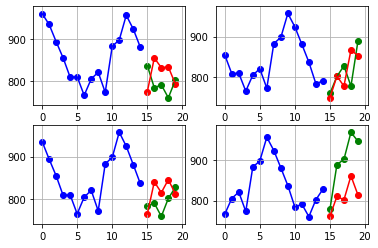

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000120, tr_loss = 0.003708, te_loss = 0.006117
grad_step = 000150, tr_loss = 0.002214, te_loss = 0.006117
grad_step = 000180, tr_loss = 0.000905, te_loss = 0.006117


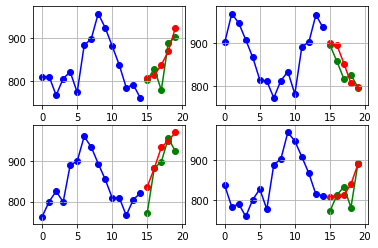

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000210, tr_loss = 0.000493, te_loss = 0.001034
grad_step = 000240, tr_loss = 0.000413, te_loss = 0.001034
grad_step = 000270, tr_loss = 0.000367, te_loss = 0.001034
grad_step = 000300, tr_loss = 0.000324, te_loss = 0.001034


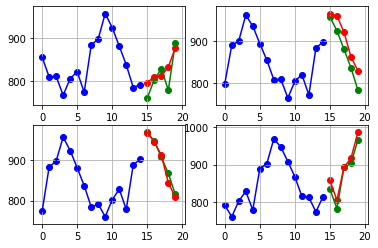

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000330, tr_loss = 0.000298, te_loss = 0.000728
grad_step = 000360, tr_loss = 0.000275, te_loss = 0.000728
grad_step = 000390, tr_loss = 0.000284, te_loss = 0.000728


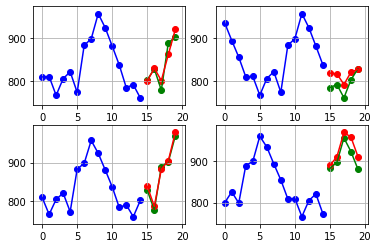

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000420, tr_loss = 0.000249, te_loss = 0.000550
grad_step = 000450, tr_loss = 0.000225, te_loss = 0.000550
grad_step = 000480, tr_loss = 0.000194, te_loss = 0.000550


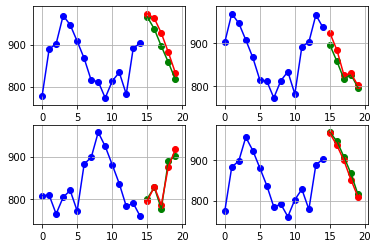

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000510, tr_loss = 0.000174, te_loss = 0.000435
grad_step = 000540, tr_loss = 0.000158, te_loss = 0.000435
grad_step = 000570, tr_loss = 0.000145, te_loss = 0.000435
grad_step = 000600, tr_loss = 0.000141, te_loss = 0.000435


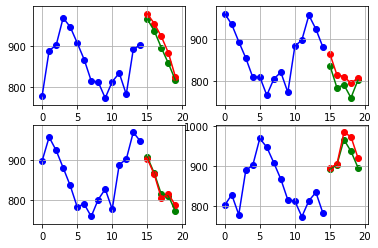

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000630, tr_loss = 0.000229, te_loss = 0.000356
grad_step = 000660, tr_loss = 0.000129, te_loss = 0.000356
grad_step = 000690, tr_loss = 0.000164, te_loss = 0.000356


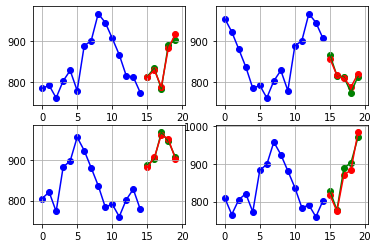

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000720, tr_loss = 0.000135, te_loss = 0.000345
grad_step = 000750, tr_loss = 0.000147, te_loss = 0.000345
grad_step = 000780, tr_loss = 0.000120, te_loss = 0.000345


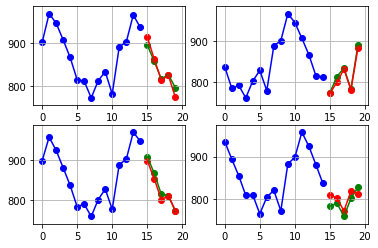

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000810, tr_loss = 0.000117, te_loss = 0.000278
grad_step = 000840, tr_loss = 0.000110, te_loss = 0.000278
grad_step = 000870, tr_loss = 0.000104, te_loss = 0.000278
grad_step = 000900, tr_loss = 0.000110, te_loss = 0.000278


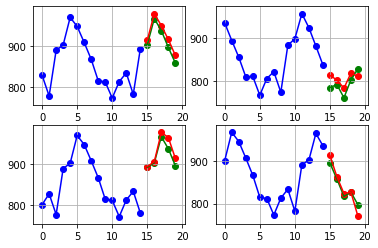

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 000930, tr_loss = 0.000107, te_loss = 0.000275
grad_step = 000960, tr_loss = 0.000105, te_loss = 0.000275
grad_step = 000990, tr_loss = 0.000108, te_loss = 0.000275


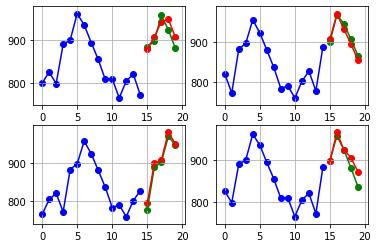

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001020, tr_loss = 0.000185, te_loss = 0.000265
grad_step = 001050, tr_loss = 0.000089, te_loss = 0.000265
grad_step = 001080, tr_loss = 0.000100, te_loss = 0.000265


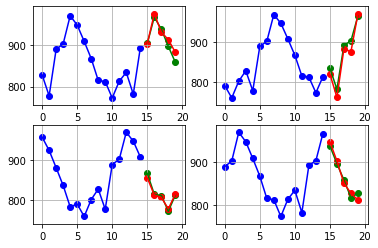

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001110, tr_loss = 0.000089, te_loss = 0.000277
grad_step = 001140, tr_loss = 0.000178, te_loss = 0.000277
grad_step = 001170, tr_loss = 0.000081, te_loss = 0.000277
grad_step = 001200, tr_loss = 0.000084, te_loss = 0.000277


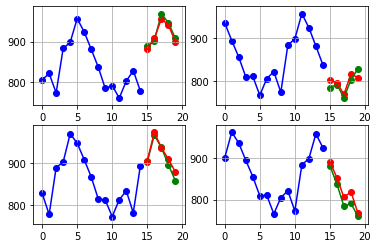

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001230, tr_loss = 0.000098, te_loss = 0.000254
grad_step = 001260, tr_loss = 0.000108, te_loss = 0.000254
grad_step = 001290, tr_loss = 0.000079, te_loss = 0.000254


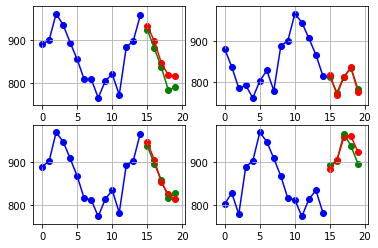

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001320, tr_loss = 0.000077, te_loss = 0.000261
grad_step = 001350, tr_loss = 0.000077, te_loss = 0.000261
grad_step = 001380, tr_loss = 0.000085, te_loss = 0.000261


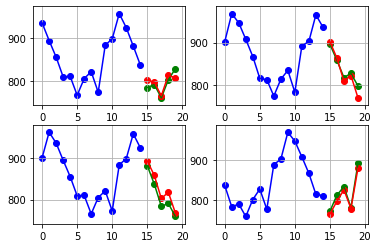

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001410, tr_loss = 0.000074, te_loss = 0.000243
grad_step = 001440, tr_loss = 0.000103, te_loss = 0.000243
grad_step = 001470, tr_loss = 0.000094, te_loss = 0.000243
grad_step = 001500, tr_loss = 0.000094, te_loss = 0.000243


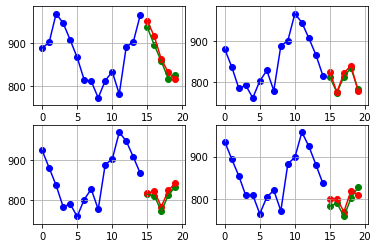

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001530, tr_loss = 0.000069, te_loss = 0.000291
grad_step = 001560, tr_loss = 0.000076, te_loss = 0.000291
grad_step = 001590, tr_loss = 0.000066, te_loss = 0.000291


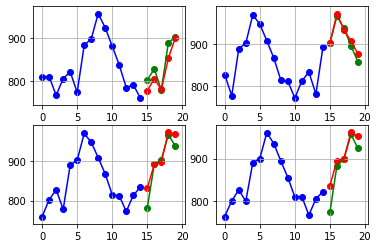

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001620, tr_loss = 0.000107, te_loss = 0.000302
grad_step = 001650, tr_loss = 0.000079, te_loss = 0.000302
grad_step = 001680, tr_loss = 0.000064, te_loss = 0.000302


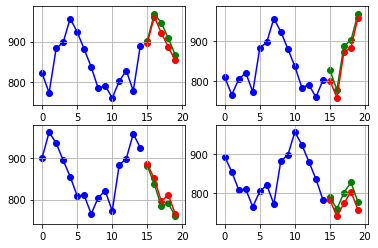

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001710, tr_loss = 0.000089, te_loss = 0.000288
grad_step = 001740, tr_loss = 0.000077, te_loss = 0.000288
grad_step = 001770, tr_loss = 0.000072, te_loss = 0.000288
grad_step = 001800, tr_loss = 0.000062, te_loss = 0.000288


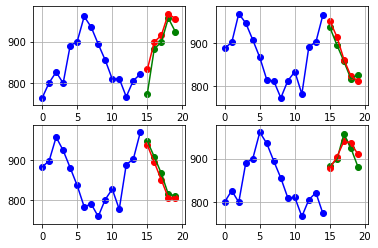

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001830, tr_loss = 0.000070, te_loss = 0.000256
grad_step = 001860, tr_loss = 0.000100, te_loss = 0.000256
grad_step = 001890, tr_loss = 0.000066, te_loss = 0.000256


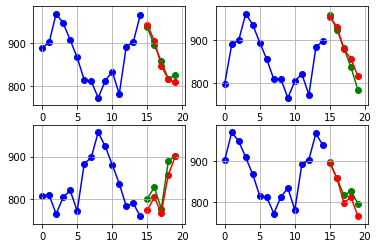

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 001920, tr_loss = 0.000102, te_loss = 0.000302
grad_step = 001950, tr_loss = 0.000097, te_loss = 0.000302
grad_step = 001980, tr_loss = 0.000073, te_loss = 0.000302


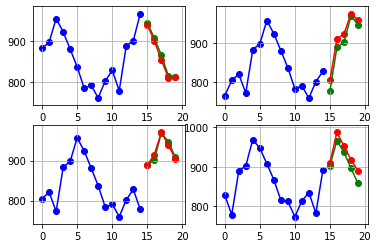

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002010, tr_loss = 0.000078, te_loss = 0.000303
grad_step = 002040, tr_loss = 0.000056, te_loss = 0.000303
grad_step = 002070, tr_loss = 0.000064, te_loss = 0.000303
grad_step = 002100, tr_loss = 0.000058, te_loss = 0.000303


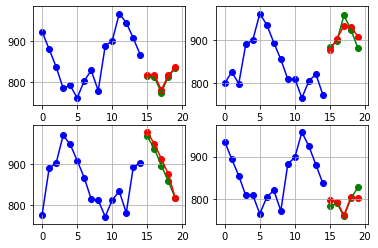

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002130, tr_loss = 0.000078, te_loss = 0.000257
grad_step = 002160, tr_loss = 0.000059, te_loss = 0.000257
grad_step = 002190, tr_loss = 0.000084, te_loss = 0.000257


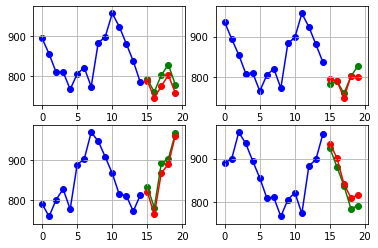

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002220, tr_loss = 0.000055, te_loss = 0.000304
grad_step = 002250, tr_loss = 0.000056, te_loss = 0.000304
grad_step = 002280, tr_loss = 0.000057, te_loss = 0.000304


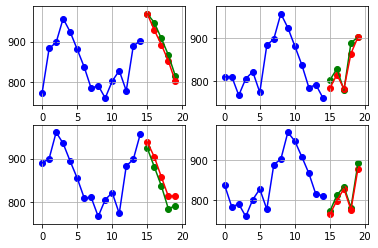

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002310, tr_loss = 0.000051, te_loss = 0.000257
grad_step = 002340, tr_loss = 0.000067, te_loss = 0.000257
grad_step = 002370, tr_loss = 0.000076, te_loss = 0.000257
grad_step = 002400, tr_loss = 0.000105, te_loss = 0.000257


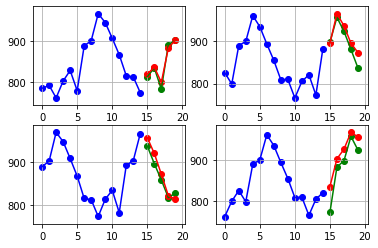

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002430, tr_loss = 0.000057, te_loss = 0.000302
grad_step = 002460, tr_loss = 0.000053, te_loss = 0.000302
grad_step = 002490, tr_loss = 0.000123, te_loss = 0.000302


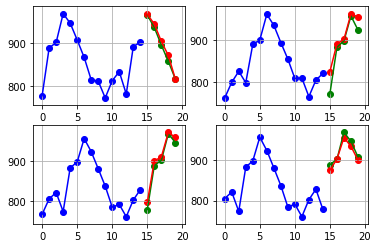

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002520, tr_loss = 0.000058, te_loss = 0.000254
grad_step = 002550, tr_loss = 0.000106, te_loss = 0.000254
grad_step = 002580, tr_loss = 0.000054, te_loss = 0.000254


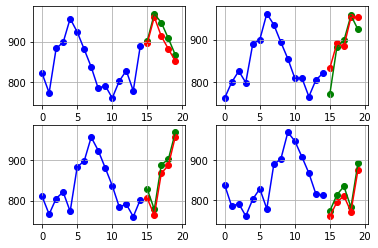

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002610, tr_loss = 0.000077, te_loss = 0.000386
grad_step = 002640, tr_loss = 0.000045, te_loss = 0.000386
grad_step = 002670, tr_loss = 0.000060, te_loss = 0.000386
grad_step = 002700, tr_loss = 0.000076, te_loss = 0.000386


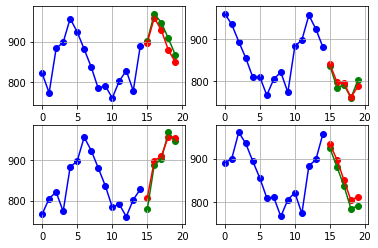

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002730, tr_loss = 0.000049, te_loss = 0.000322
grad_step = 002760, tr_loss = 0.000040, te_loss = 0.000322
grad_step = 002790, tr_loss = 0.000125, te_loss = 0.000322


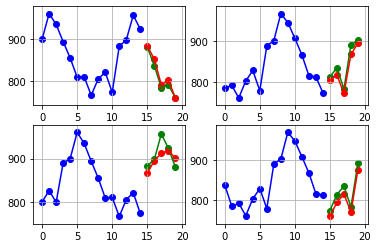

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002820, tr_loss = 0.000051, te_loss = 0.000331
grad_step = 002850, tr_loss = 0.000056, te_loss = 0.000331
grad_step = 002880, tr_loss = 0.000069, te_loss = 0.000331


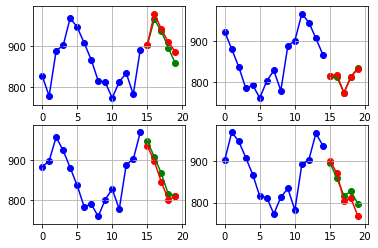

Restored checkpoint from nbeats-training-checkpoint.th.
grad_step = 002910, tr_loss = 0.000050, te_loss = 0.000273
grad_step = 002940, tr_loss = 0.000059, te_loss = 0.000273
grad_step = 002970, tr_loss = 0.000044, te_loss = 0.000273
grad_step = 003000, tr_loss = 0.000202, te_loss = 0.000273


In [9]:
# training
# model seems to converge well around ~2500 grad steps and starts to overfit a bit after.
test_losses = []
for i in range(30):
    eval_test(backcast_length, forecast_length, net, norm_constant, test_losses, x_test, y_test)
    train_100_grad_steps(data, device, net, optimiser, test_losses)